In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from random import choice
from copy import deepcopy
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10) #(6, 5)
from IPython.display import clear_output
from random import random
#import seaborn as sns
import collections
%autosave 60
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from random import shuffle

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Autosaving every 6 seconds


In [2]:
# save network to SNAP format
def net_to_snap(net, path):
    with open(path, 'w') as f:
        for i, j in net.edges():
            f.write(str(i) + '\t' + str(j) + '\r\n')
            if i != j: f.write(str(j) + '\t' + str(i) + '\r\n')

def giant_component(G, verbose=True):
    G_g = max(nx.connected_component_subgraphs(G), key=len)
    if verbose: print('Size reduced from', G.number_of_nodes(), 'to', G_g.number_of_nodes())
    return G_g

# vote share
def vote_share(G):
    cnt = 0
    for node in G: cnt += G.node[node]['vote']
    return cnt/G.number_of_nodes()
    
def print_vote_share(G):
    print('Positive votes: ', round(vote_share(G), 3))

In [3]:
# ratio of positive and negative votes in first neighbourhood of node
def calc_nb1_ratio_node(G, node):
    nb_sum = 0
    for nb in nx.neighbors(G, node):
        nb_sum += G.node[nb]['vote']
    if G.node[node]['vote']:
        if not nb_sum: return np.nan
        return (G.degree(node)-nb_sum)/nb_sum
    else:
        if not (G.degree(node)-nb_sum): return np.nan
        return nb_sum / (G.degree(node)-nb_sum)
    
# save nb1 vore ratios to nodes
def calc_nb1_ratio(G):
    for node in G:
        G.node[node]['nb1_ratio'] = calc_nb1_ratio_node(G, node)

# share of positive and negative votes in first neighbourhood of node
def calc_nb1_node(G, node):
    nb_sum = G.node[node]['vote']
    for nb in nx.neighbors(G, node):
        nb_sum += G.node[nb]['vote']
    return nb_sum / (G.degree(node)+1)
    
# save nb1 vote shares to nodes
def calc_nb1(G):
    for node in G:
        G.node[node]['nb1'] = calc_nb1_node(G, node)

In [4]:
# save nb2 vote shares to nodes
def calc_nb2(G, node_att = 'vote', ego_att_vals = [0,1], nb_att_vals = [0,1], focused_vote = 1, nb2_att = 'nb2'):
    for node in G.nodes():
        if not G.degree(node): continue
        node_vote = G.node[node][node_att]
        if node_vote not in ego_att_vals: continue
        eq_nb_cnt = 0.0
        nb2 = []
        for nb in nx.neighbors(G, node):
            nb2 += nx.neighbors(G, nb)
        if not nb2: continue
        nb2_cnt = 0
        for nb in nb2:
            if G.node[nb][node_att] not in nb_att_vals: continue
            nb2_cnt += 1
            if focused_vote is None:
                if G.node[nb][node_att] == node_vote: eq_nb_cnt += 1
            else:
                if G.node[nb][node_att] == focused_vote: eq_nb_cnt += 1
        if not nb2_cnt: continue
        G.node[node][nb2_att] = eq_nb_cnt / nb2_cnt
        G.node[node][nb2_att+'_cnt'] = nb2_cnt

In [5]:
'''Vote share estimators'''

def estimator_trivial(G, nodes):
    cnt = 0
    for node in nodes: cnt += G.node[node]['vote']
    return cnt/len(nodes)

def estimator_trivial_nb(G, nodes):
    nbs = set(nodes)
    for node in nodes:
        nbs = nbs.union(nx.neighbors(G, node))
    return estimator_trivial(G, nbs)

def estimator_ratio(G, nodes):
    a, b = distribution_mean(G, nodes, 'nb1_ratio')
    return (-b + sqrt(a*b))/(a - b)

def estimator_ratio_micro(G, nodes):
    norm_sums = [[0,0],[0,0]]
    for node in nodes:
        if 'nb1' in G.node[node]:
            if not np.isnan(G.node[node]['nb1']):
                vote = G.node[node]['vote']
                nb1 = G.node[node]['nb1']
                norm_sums[vote][1] += nb1
                norm_sums[vote][0] += 1 - nb1
    a = norm_sums[1][0] / norm_sums[1][1]
    b = norm_sums[0][1] / norm_sums[0][0]
    return (-b + sqrt(a*b))/(a - b)

def estimator_ratio_2pin(G, nodes):
    a, b = distribution_mean(G, nodes, 'nb1_ratio')
    x1 = (p_in_a - 1)/(-a*p_in_a + p_in_a - 1)
    x2 = b*p_in_b/(b*p_in_b - p_in_a + 1)
    return (x1+x2)/2

def estimator_ratio_2pin_approx(G, nodes):
    R = estimator_R(G, nodes)
    Ra, Rb = R['Ra'], R['Rb']
    a, b = distribution_mean(G, nodes, 'nb1_ratio')
    x1 = Ra / (a + Ra)
    x2 = b / (b + Rb)
    return x1, x2

def estimator_ratio_2pin_approx_arit(G, nodes):
    x1, x2 = estimator_ratio_2pin_approx(G, nodes)
    return (x1 + x2) / 2

def estimator_ratio_2pin_approx_geom(G, nodes):
    x1, x2 = estimator_ratio_2pin_approx(G, nodes)
    return sqrt(x1 * x2)

def estimator_ratio_2pin_approx_harm(G, nodes):
    x1, x2 = estimator_ratio_2pin_approx(G, nodes)
    return 2 / ((1/x1) + (1/x2))


def estimator_ratio_2pin_1(G, nodes):
    a, b = distribution_mean(G, nodes, 'nb1_ratio')
    return (p_in_a - 1)/(-a*p_in_a + p_in_a - 1)


def estimator_ratio_2pin_2(G, nodes):
    a, b = distribution_mean(G, nodes, 'nb1_ratio')
    return b*p_in_b/(b*p_in_b - p_in_a + 1)

def estimator_fraction_nb1(G, nodes):
    a, b = distribution_mean(G, nodes, 'nb1')
    sqrt_val = sqrt(a*b - (a**2)*b - a*(b**2) + (a**2)*(b**2))
    x = (a*b-sqrt_val)/(a+b-1)
    return x

def estimator_fraction_nb1_reciprocal(G, nodes):
    a, b = distribution_mean(G, nodes, 'nb1')
    a = 1 - a
    b = 1 - b
    sqrt_val = sqrt(a*b - (a**2)*b - a*(b**2) + (a**2)*(b**2))
    x = (a*b-sqrt_val)/(a+b-1)
    return 1 - x

def estimator_fraction_nb2(G, nodes):
    a, b = distribution_mean(G, nodes, 'nb2')
    sqrt_val = sqrt(a*b - (a**2)*b - a*(b**2) + (a**2)*(b**2))
    x = (a*b-sqrt_val)/(a+b-1)
    return x

def distribution_mean(G, nodes, att):
    vote_nb_sum = [0,0]
    vote_nb_cnt = [0,0]
    for node in nodes:
        if att in G.node[node]:
            if not np.isnan(G.node[node][att]):
                vote = G.node[node]['vote']
                vote_nb_sum[vote] += G.node[node][att]
                vote_nb_cnt[vote] += 1
    if not vote_nb_cnt[0]: vote_nb_cnt[0] = 1
    if not vote_nb_cnt[1]: vote_nb_cnt[1] = 1
    a = vote_nb_sum[1] / vote_nb_cnt[1]
    b = vote_nb_sum[0] / vote_nb_cnt[0]
    return a, b



def estimator_R(G, nodes):
    cnt1 = int(estimator_trivial(G, nodes) * len(nodes))
    cnt0 = len(nodes) - cnt1
    nodes = set(nodes)
    max_00 = (cnt0 * (cnt0 - 1))/2
    max_11 = (cnt1 * (cnt1 - 1))/2
    max_10 = cnt0 * cnt1
    edge_cnt = {(0,0): 0, (1,1): 0, (0,1): 0, (1,0): 0, }
    for i, j in G.edges():
        if i in nodes and j in nodes:
            edge_cnt[(G.node[i]['vote'],G.node[j]['vote'])] += 1
    cnt_out = edge_cnt[(0,1)] + edge_cnt[(1,0)]
    cnt_in_a = edge_cnt[(1,1)]
    cnt_in_b = edge_cnt[(0,0)]
    p_out = cnt_out/(max_10)
    p_in_a = cnt_in_a / max_11
    p_in_b = cnt_in_b / max_00
    return {'Ra': p_out/p_in_a, 'Rb':p_out/p_in_b}

def estimator_Ra(G, nodes):
    return estimator_R(G, nodes)['Ra']

def estimator_Rb(G, nodes):
    return estimator_R(G, nodes)['Rb']

def estimator_constdeg_macro(G, nodes):
    cnt = [[0,0],[0,0]]
    for node in nodes:
        vote = G.node[node]['vote']
        for nb in nx.neighbors(G, node):
            votenb = G.node[nb]['vote']
            cnt[vote][votenb] += 1
    print(cnt)
    if not cnt[1][1] or not cnt[0][0]: return np.nan
    a = cnt[1][0] / cnt[1][1]
    b = cnt[0][1] / cnt[0][0]
    return b*(a + 1)/(2*a*b + a + b)


def estimator_constdeg_micro(G, nodes):
    a, b = distribution_mean(G, nodes, 'nb1_ratio')
    if (2*a*b + a + b) == 0: return np.nan
    return b*(a + 1)/(2*a*b + a + b)


In [6]:
'''Kronecker model utility methods'''

def net_from_kron(x, n0, n1, p_switch):
    n = x.shape[0]
    n0_kron = int(n * n0 / (n0+n1))
    G = nx.Graph()
    for i in range(n):
        cls = 0 if i < n0_kron else 1
        if random() < p_switch: cls = 1 - cls
        G.add_node(i, vote=cls)
    for i in range(n):
        for j in range(i, n):
            if random() < x[i,j]: G.add_edge(i,j)
    return G

def net_from_kron_constdeg(x, n0, n1, p_switch, const_deg = 10):
    n = x.shape[0]
    n0_kron = int(n * n0 / (n0+n1))
    G = nx.DiGraph()
    for i in range(n):
        cls = 0 if i < n0_kron else 1
        if random() < p_switch: cls = 1 - cls
        G.add_node(i, vote=cls)
    for i in range(n):
        p = x[i] / x[i].sum()
        nbs = choice(np.array(list(range(n))), const_deg, p=p, replace = False)
        for nb in nbs:
            G.add_edge(i, nb)
    return G

# generate a polarized kronecker network
def gen_2cls_net(n0, n1, p_in, p_out, K1, iters, p_switch, adj_dist_plot = False, 
                 kron2 = False, verbose=False, n_nets = 1, p_in_b = None, net_from_kron = net_from_kron):
    if p_in_b is None: p_in_b = p_in
    row0 = [p_in_b] * n0 + [p_out] * n1
    row1 = [p_out] * n0 + [p_in] * n1
    arr = [row0] * n0 + [row1] * n1
    x = np.array(arr)
    
    for i in range(iters):
        x = np.kron(x,K1)
        if verbose: print(i, '/', iters)
    if kron2: x = x.dot(x)
    
    if adj_dist_plot:
        plot_mat_nb2_dist(x, n0, n1)
    if verbose: clear_output() 
    #print(x.max(), x.min(), x.mean())

    for i in range(n_nets):
        G = net_from_kron(x, n0, n1, p_switch)
        if n_nets == 1:
            print('Generated network: N =', G.number_of_nodes(), ' E =', G.number_of_edges())
        yield G

In [7]:
from numpy.random import choice

def sample_predictions(G, sample_size, iters, estimators, bias_att = None, beta = 0.5, reverse = False):
    n = G.number_of_nodes()
    nodes = G.nodes()
    if bias_att is None:
        weights = np.ones(n)
    else:
        weights = np.array([G.node[node][bias_att] for node in nodes])
        if reverse: weights = weights.max() - weights
        weights = beta * weights + (1 - beta)
                
    weights = weights / weights.sum()
    
    results = []
    for i in range(iters):
        draw = choice(nodes, sample_size, p=weights, replace = False)
        results += [[estimator(G, draw) for estimator in estimators]]
        
    results = np.array(results)
    means = results.mean(axis=0)
    stds = results.std(axis=0)
    return means, stds

In [8]:
from scipy.stats import norm

def plot_range(x, y, margin, label, color):
    plt.plot(x, y, color=color, alpha=0.5, label=label)
    plt.plot(x, y-margin, color=color, alpha=0.2)
    plt.plot(x, y+margin, color=color, alpha=0.2)
    plt.fill_between(x, y-margin, y+margin, alpha=0.05, edgecolor=color, facecolor=color)
    

def plot_model_performance(G, n_size_steps, iters, bias_att = None, beta = 0.5, reverse = False, sample_size_limit = 1):
    n = G.number_of_nodes()
    
    estimators = [
        (estimator_trivial, 'Trivial', 'grey'),
        (estimator_trivial_nb, 'Neighbourhood trivial', 'green'),
        (estimator_fraction_nb1, 'First neighbourhood', 'purple'),
        #(estimator_fraction_nb2, 'Second neighbourhood', 'blue')
        #(estimator_fraction_nb1_reciprocal, 'Reciprocal', 'purple')
        (estimator_ratio, 'Them vs. us', 'blue'),
        #(estimator_ratio_2pin, 'Them vs. us for different p_in', 'blue'),
        #(estimator_ratio_2pin_approx_arit, 'Them vs. us for different p_in arit', 'red'),
        #(estimator_ratio_2pin_approx_geom, 'Them vs. us for different p_in geom', 'blue'),
        #(estimator_ratio_2pin_approx_harm, 'Them vs. us for different p_in harm', 'orange')
        #(estimator_ratio_2pin_1, 'Them vs. us for different p_in', 'orange'),
        #(estimator_ratio_2pin_2, 'Them vs. us for different p_in', 'red')
        #(estimator_Ra, 'Ra', 'red'),
        #(estimator_Rb, 'Rb', 'blue')
        #(estimator_constdeg_macro, 'Constdeg macro', 'blue')
        #(estimator_constdeg_micro, 'Constdeg micro', 'red')
        #(estimator_ratio_micro, 'Them vs. us micro', 'red')
    ]
    
    means_list = []
    stds_list = []
    x = []
    for i in range(n_size_steps):
        print(i)
        sample_size = int((i+1) * (n*sample_size_limit) / n_size_steps)
        x += [sample_size / n]
        means, stds = sample_predictions(G, sample_size, iters, [met[0] for met in estimators], bias_att, beta, reverse)
        means_list += [means]
        stds_list += [stds]
    clear_output()
    
    means_np = np.array(means_list).T
    stds_np = np.array(stds_list).T
        
    true_p = vote_share(G)
    errors = (means_np[:,-1] - true_p).ravel()
    for i, estimator in enumerate(estimators):
        method, label, color = estimator
        err_str = str(np.round(errors[i] * 100,2))
        plot_range(x, means_np[i], stds_np[i], label + ' (err ' + err_str + '%)', color)
    plt.axhline(y=true_p, color='black', label='True percentage', linewidth=0.5)
    plt.legend()
    #plt.show()

Generate a polarized Kronecker netowork using a K1 fitted on a Croatian referendum data.

In [9]:
kron = np.array([[0.770117, 0.794312], [0.794312, 0.0965146]])
n0 = 1
n1 = 2
p_in_a = 1
p_in_b = 1
G = list(gen_2cls_net(n0,n1, p_in_a, 0.1, kron, 12, 0, verbose=True, p_in_b=p_in_b))[0]
print_vote_share(G)
#G = giant_component(G)
true_p = vote_share(G)
print('Positive votes: ', round(true_p, 3))
calc_nb1(G)
#calc_nb2(G)
calc_nb1_ratio(G)
print('std =', sqrt((n0/(n0+n1)) * (n1/(n0+n1))))

Generated network: N = 12288  E = 129476
Positive votes:  0.667
Positive votes:  0.667
std = 0.471404520791


Plot estimator results for sampling bias $\beta = [0,0.3,0.5]$

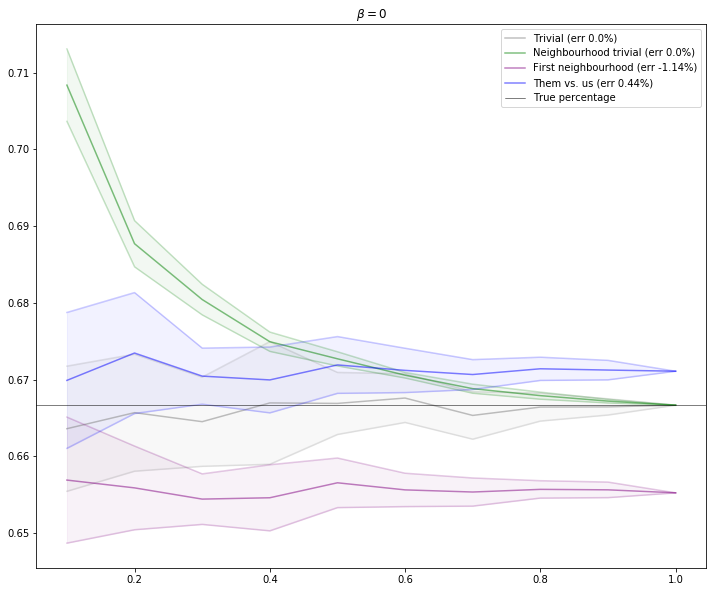

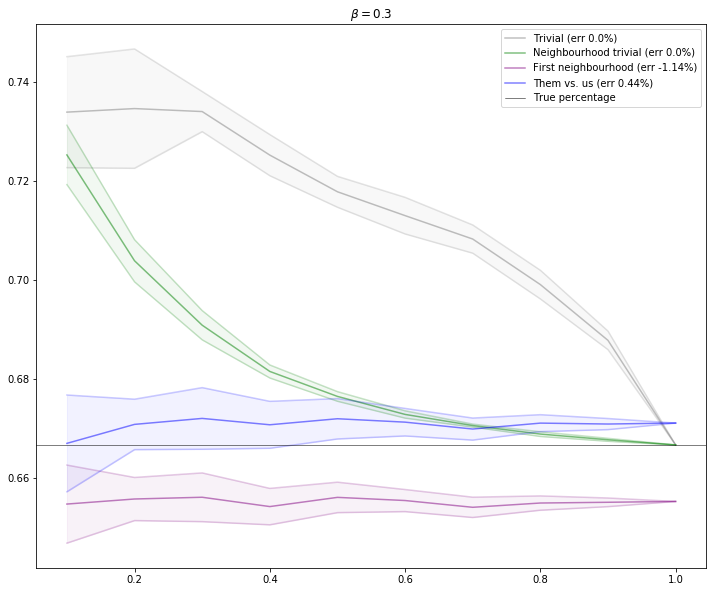

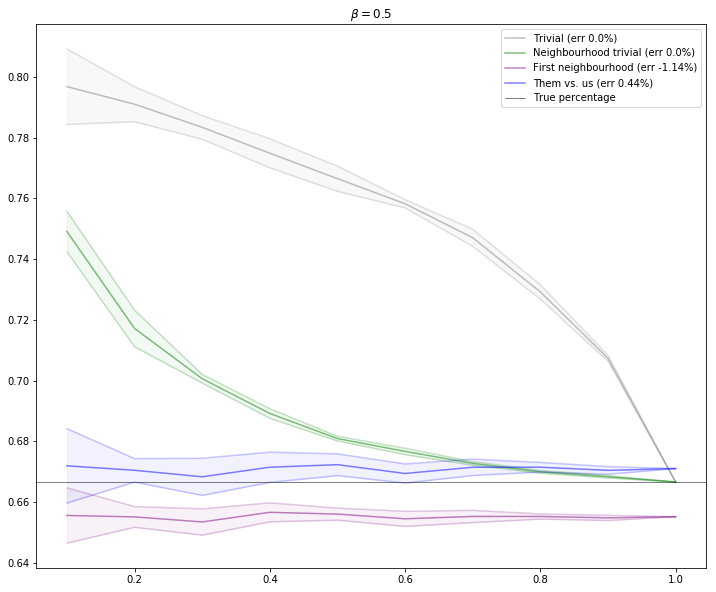

In [10]:
for beta in [0, 0.3, 0.5]:
    plt.figure()
    plt.title(r'$\beta = $' + str(beta))
    plot_model_performance(G, 10, 10, bias_att='vote', beta = beta)